In [6]:
!pip install noisereduce
!pip install praat-parselmouth
!pip install --upgrade librosa
!pip install librosa scipy
!pip install pysptk

In [7]:
import pandas as pd
import numpy as np
import librosa
import parselmouth
from parselmouth.praat import call
import scipy.stats as stats
import scipy
import pysptk
from scipy.io import wavfile
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!pip install -U path.py
import os
from path import Path
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load File

In [10]:
features_df = pd.read_csv('/content/drive/Shared drives/CS298/CS 297/IEMOCAP/features_labeled.csv')
features_df['Emotion'] = features_df['Emotion'].str.strip().str.lower()
features_df

,MFCC_0,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,...,LPC_3,LPC_4,LPC_5,LPC_6,LPC_7,LPC_8,LPC_9,LPC_10,Emotion,Speaker_id
0,-655.36590,50.261032,-3.104844,32.091267,13.332153,18.607740,3.604465,10.685017,4.742235,13.920569,...,-4.511210,4.394055,-4.093338,3.435719,-2.491161,1.618545,-0.841345,0.231878,nervous,Ses04F_script03_1_M000
1,-516.27920,81.938736,-11.943563,54.832817,-15.571386,-1.898250,-5.005520,-0.433613,-8.996594,11.690087,...,-2.792954,2.968330,-2.780188,2.353076,-1.817657,1.220398,-0.690810,0.307255,nervous,Ses04F_script03_1_F000
2,-427.83640,129.667370,-36.215020,32.703940,-16.686940,-13.942565,-4.956258,-10.092444,-12.955050,7.133200,...,-4.744764,4.642851,-3.985493,3.145189,-2.376613,1.746918,-1.050510,0.365540,nervous,Ses04F_script03_1_M001
3,-513.93710,88.305050,-18.457039,24.486145,-8.215335,1.251276,-27.179890,-11.975879,-5.173810,-4.929144,...,-3.090165,3.320948,-3.247216,2.940113,-2.435372,1.822004,-1.057869,0.373655,nervous,Ses04F_script03_1_F001
4,-536.65260,81.191770,4.736147,36.735870,-3.965307,16.663223,-7.575291,3.825757,-8.654832,5.344074,...,-3.553042,3.462163,-3.325728,2.993844,-2.321306,1.518272,-0.814908,0.289061,nervous,Ses04F_script03_1_M002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,-763.35690,101.648186,10.663176,47.480778,3.724019,30.975050,3.929498,3.665331,-7.496144,8.215463,...,-1.170120,1.284586,-0.959532,0.933867,-0.806751,0.466919,-0.325619,0.236596,neutral,Ses05F_script01_3_F024
1270,-738.53600,68.699290,3.973536,43.911053,9.789231,15.130494,6.955147,9.605745,6.055685,9.707150,...,-3.298302,3.244579,-3.122291,2.698271,-1.941852,1.265762,-0.622597,0.176976,nervous,Ses05F_script01_3_M039
1271,-729.83200,53.490160,3.229769,31.867926,-10.114451,-3.606077,-12.762634,-5.845935,-4.229926,-3.481748,...,-1.815640,1.916851,-1.697861,1.516598,-1.163930,0.806802,-0.447886,0.190043,sad,Ses05F_script01_3_F025
1272,-702.53143,65.300705,-3.214799,34.498547,3.852959,4.639018,-7.179932,4.176220,-4.343123,0.713959,...,-2.520886,2.456408,-2.512252,2.124132,-1.619765,1.180938,-0.630181,0.283970,nervous,Ses05F_script01_3_M040


In [14]:
import os
import pandas as pd

# Base path to the session folders
base_path = '/content/drive/Shared drives/CS298/CS 297/IEMOCAP'

# Initialize an empty list to store the data
data = []

# Loop through each session folder
for session in range(1, 6):
    # Define the path to the transcriptions folder
    transcription_path = f'{base_path}/Session{session}/dialog/transcriptions'
    print(transcription_path)
    # Loop through each transcription file in the folder
    for filename in os.listdir(transcription_path):
        # Check if the file is a text file
        if filename.endswith('.txt'):
            # Open the text file
            with open(os.path.join(transcription_path, filename), 'r') as file:
                # Read the file line by line
                for line in file:
                    # Split the line at the ':'
                    parts = line.strip().split(':')
                    if len(parts) == 2:
                        # Extract speaker_id and transcript
                        speaker_id = parts[0].split(' ')[0]
                        transcript = parts[1].strip()
                        # Append to the list
                        data.append([speaker_id, transcript])

# Create a DataFrame from the collected data
df = pd.DataFrame(data, columns=['Speaker_id', 'Transcript'])

# Display the DataFrame
print(df)


/content/drive/Shared drives/CS298/CS 297/IEMOCAP/Session1/dialog/transcriptions
/content/drive/Shared drives/CS298/CS 297/IEMOCAP/Session2/dialog/transcriptions
/content/drive/Shared drives/CS298/CS 297/IEMOCAP/Session3/dialog/transcriptions
/content/drive/Shared drives/CS298/CS 297/IEMOCAP/Session4/dialog/transcriptions
/content/drive/Shared drives/CS298/CS 297/IEMOCAP/Session5/dialog/transcriptions
                   Speaker_id  \
0         Ses01F_impro01_F000   
1         Ses01F_impro01_M000   
2         Ses01F_impro01_F001   
3         Ses01F_impro01_M001   
4         Ses01F_impro01_F002   
...                       ...   
10234  Ses05M_script02_2_M038   
10235  Ses05M_script02_2_F037   
10236  Ses05M_script02_2_M039   
10237  Ses05M_script02_2_F038   
10238  Ses05M_script02_2_M040   

                                              Transcript  
0                                             Excuse me.  
1                                Do you have your forms?  
2                    

In [15]:
df

,Speaker_id,Transcript
0,Ses01F_impro01_F000,Excuse me.
1,Ses01F_impro01_M000,Do you have your forms?
2,Ses01F_impro01_F001,Yeah.
3,Ses01F_impro01_M001,Let me see them.
4,Ses01F_impro01_F002,Is there a problem?
...,...,...
10234,Ses05M_script02_2_M038,Are you still cold? Still want to go home?
10235,Ses05M_script02_2_F037,No. I'm beginning to think you might be right...
10236,Ses05M_script02_2_M039,"Shh. If we're really quiet, the fish might come."
10237,Ses05M_script02_2_F038,Or not.


In [93]:
merged_df = pd.merge(df, features_df, on='Speaker_id', how='inner')[['Speaker_id','Transcript','Emotion']]
merged_df.head()

,Speaker_id,Transcript,Emotion
0,Ses02M_impro06_F000,What's going on?,sad
1,Ses02M_impro06_M000,Kathy died last night.,sad
2,Ses02M_impro06_F001,"Oh my God. Oh my God, I'm so sorry.",sad
3,Ses02M_impro06_M001,"yeah, I mean, you know, it was a -",sad
4,Ses02M_impro06_M002,I guess we saw it coming and she lasted a lot ...,sad


In [27]:
import pandas as pd
import re

# Assuming 'merged_df' is your DataFrame containing the 'Emotion' and 'Transcript' columns

# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove non-alphanumeric characters (keeping spaces)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

# Apply the preprocessing function to the 'Transcript' column
merged_df['Transcript'] = merged_df['Transcript'].apply(preprocess_text)

# Display the first few entries to verify changes
merged_df.head()


,Transcript,Emotion
0,whats going on,sad
1,kathy died last night,sad
2,oh my god oh my god im so sorry,sad
3,yeah i mean you know it was a,sad
4,i guess we saw it coming and she lasted a lot ...,sad


In [28]:
merged_df['Emotion'] = merged_df['Emotion'].replace('excited', 'happy')
merged_df = merged_df[~merged_df['Emotion'].str.contains('nervous', na=False)]


In [29]:
# Recalculate the emotion counts
emotion_counts = merged_df['Emotion'].value_counts()

# Print the updated counts
for emotion, count in emotion_counts.items():
    print(f"{emotion}: {count}")

happy: 308
neutral: 291
angry: 273
sad: 271


In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'merged_df' is your DataFrame containing the 'Emotion' and 'Transcript' columns

# Text preprocessing
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(merged_df['Transcript'])
y = merged_df['Emotion']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Logistic Regression model
model = LogisticRegression(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict the test set results
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.43137254901960786
              precision    recall  f1-score   support

       angry       0.54      0.39      0.45        64
     excited       0.00      0.00      0.00         3
       happy       0.53      0.56      0.54        61
     nervous       0.33      0.11      0.16        19
     neutral       0.33      0.44      0.38        62
         sad       0.38      0.48      0.42        46

    accuracy                           0.43       255
   macro avg       0.35      0.33      0.33       255
weighted avg       0.44      0.43      0.42       255



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=1000)

# Apply the vectorizer to the Transcript column
X = vectorizer.fit_transform(merged_df['Transcript'])
y = merged_df['Emotion']

# Proceed with splitting the data and training the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
model = LogisticRegression(random_state=42, multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)

# Predict the emotions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.43529411764705883
              precision    recall  f1-score   support

       angry       0.51      0.36      0.42        64
     excited       0.00      0.00      0.00         3
       happy       0.53      0.52      0.53        61
     nervous       0.22      0.11      0.14        19
     neutral       0.37      0.48      0.42        62
         sad       0.41      0.52      0.46        46

    accuracy                           0.44       255
   macro avg       0.34      0.33      0.33       255
weighted avg       0.43      0.44      0.43       255



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Text tokenization and padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(merged_df['Transcript'])
sequences = tokenizer.texts_to_sequences(merged_df['Transcript'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

# Label encoding
encoder = LabelEncoder()
y = encoder.fit_transform(merged_df['Emotion'])
y = tf.keras.utils.to_categorical(y)  # Convert labels to one-hot encoding

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)


In [38]:
merged_df['Transcript'].apply(lambda x: len(x.split())).max()

85

In [81]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# Generate an array of indices the same length as dataset
indices = np.arange(padded_sequences.shape[0])
# Text tokenization and padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(merged_df['Transcript'])
sequences = tokenizer.texts_to_sequences(merged_df['Transcript'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

# Label encoding
encoder = LabelEncoder()
y = encoder.fit_transform(merged_df['Emotion'])
y = tf.keras.utils.to_categorical(y)  # Convert labels to one-hot encoding

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    padded_sequences, y, indices, test_size=0.2, random_state=42)

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

from tensorflow.keras.optimizers import Adam

# Initialize the Adam optimizer with a custom learning rate
learning_rate = 0.001  # You can adjust this value
optimizer = Adam(learning_rate=learning_rate)

# Model definition remains the same
'''
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=85),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])
'''
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=85),
    LSTM(64),  # Using a single LSTM layer
    Dense(32, activation='relu'),
    Dense(y.shape[1], activation='softmax')  # Output layer with one neuron per class
])

# Compile the model with the custom optimizer
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Training the model with adjusted learning rate
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=32)



Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.2358 - loss: 1.3873 - val_accuracy: 0.2576 - val_loss: 1.3878
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.2659 - loss: 1.3865 - val_accuracy: 0.2576 - val_loss: 1.3861
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.2835 - loss: 1.3847 - val_accuracy: 0.2576 - val_loss: 1.3858
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.2667 - loss: 1.3856 - val_accuracy: 0.2576 - val_loss: 1.3865
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.2859 - loss: 1.3837 - val_accuracy: 0.2576 - val_loss: 1.3863
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.2824 - loss: 1.3835 - val_accuracy: 0.2576 - val_loss: 1.3860
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.2390 - loss: 1.3885 - val_accuracy: 0.2576 - val_loss: 1.3859
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.2840 - loss: 1.3839 - val_accuracy: 0.2576 - 

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical

def evaluate_model(model, X_test, y_test, history, class_labels):
    # Evaluate the model on the test data
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print("Test Accuracy:", test_acc)

    # Predict the test set results for F1 and Confusion Matrix
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Compute the F1 Score
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    print("F1 Score:", f1)

    # Generate and display the confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    print("Confusion Matrix:\n", cm)

    # Classification report
    print(classification_report(y_true_classes, y_pred_classes))

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Example of using the function
# Assuming 'model', 'X_test', 'y_test', 'history', and 'encoder.classes_' are defined and available
evaluate_model(model, X_test, y_test, history, encoder.classes_)


In [101]:
def model_1(vocab_size, output_size):
    tf.random.set_seed(42)
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=40, input_length=85),
        Bidirectional(LSTM(100)),
        Dense(output_size, activation='softmax')
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [102]:
from tensorflow.keras.callbacks import EarlyStopping

# Assuming vocab_size from tokenizer and output_size from label_encoder
vocab_size = 10000  # or len(tokenizer.word_index) + 1
output_size = len(encoder.classes_)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the lowest validation loss
)
# Initialize the model
model = model_1(vocab_size, output_size)

# Train the model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test),
                    batch_size=32, callbacks=[early_stopping])

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.2689 - loss: 1.3858 - val_accuracy: 0.2751 - val_loss: 1.3750
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.3603 - loss: 1.3657 - val_accuracy: 0.3406 - val_loss: 1.3501
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.4368 - loss: 1.3113 - val_accuracy: 0.4061 - val_loss: 1.3029
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - accuracy: 0.5507 - loss: 1.1602 - val_accuracy: 0.3755 - val_loss: 1.2614
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 0.6361 - loss: 0.9357 - val_accuracy: 0.4236 - val_loss: 1.2036
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.7345 - loss: 0.7400 - val_accuracy: 0.4498 - val_loss: 1.2448
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 0.7705 - loss: 0.6318 - val_accuracy: 0.4498 - val_loss: 1.3162
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step - accuracy: 0.8198 - loss: 0.5201 - val_accuracy: 0

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4084 - loss: 1.2255
Test Accuracy: 0.4235807955265045
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
F1 Score: 0.41413766787124834
Confusion Matrix:
 [[29  9 13  4]
 [ 8 32 14  5]
 [15 17 26  7]
 [ 9  8 23 10]]
              precision    recall  f1-score   support

           0       0.48      0.53      0.50        55
           1       0.48      0.54      0.51        59
           2       0.34      0.40      0.37        65
           3       0.38      0.20      0.26        50

    accuracy                           0.42       229
   macro avg       0.42      0.42      0.41       229
weighted avg       0.42      0.42      0.41       229



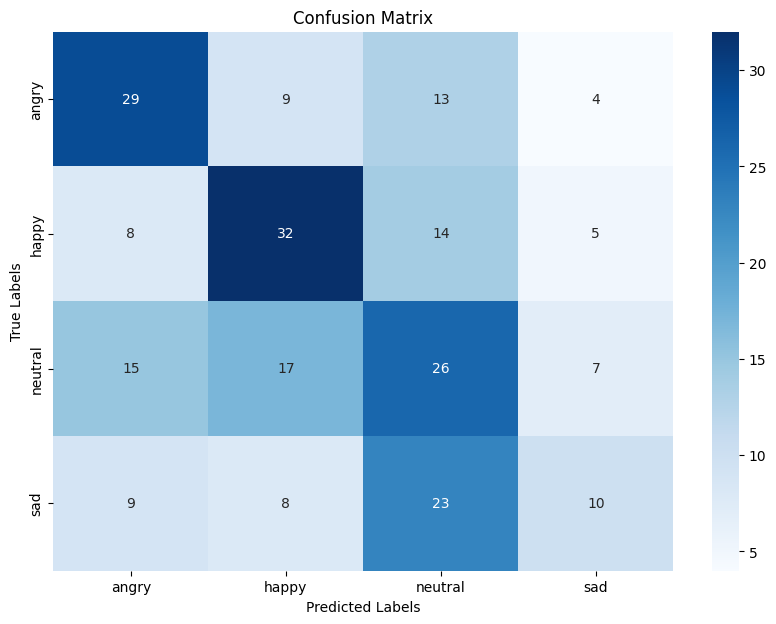

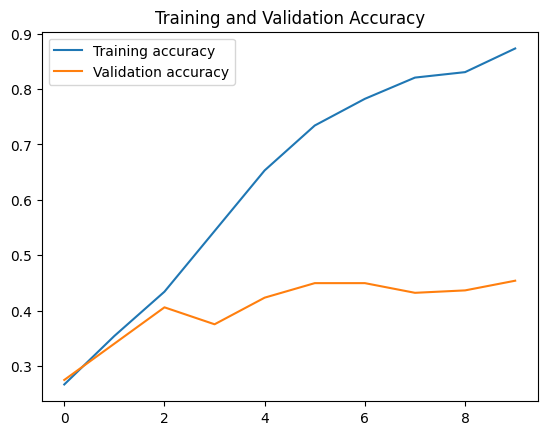

In [103]:
evaluate_model(model, X_test, y_test, history, encoder.classes_)


### Attention

In [114]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class Attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")

        super(Attention, self).build(input_shape)

    def call(self, x):
        # Applying the attention mechanism
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a

        if self.return_sequences:
            return output

        return K.sum(output, axis=1)


def build_model(vocab_size, output_size):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=85),
        Bidirectional(LSTM(100, return_sequences=True)),
        Attention(return_sequences=False),  # Use attention mechanism
        Dense(64, activation='relu'),
        Dense(output_size, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# Example usage
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the lowest validation loss
)
model = build_model(vocab_size=10000, output_size=4)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 249ms/step - accuracy: 0.2624 - loss: 1.3892 - val_accuracy: 0.2576 - val_loss: 1.3865
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.2259 - loss: 1.3895 - val_accuracy: 0.2576 - val_loss: 1.3889
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 244ms/step - accuracy: 0.2356 - loss: 1.3894 - val_accuracy: 0.2576 - val_loss: 1.3843
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 0.2692 - loss: 1.3861 - val_accuracy: 0.2576 - val_loss: 1.3824
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 261ms/step - accuracy: 0.2781 - loss: 1.3811 - val_accuracy: 0.2969 - val_loss: 1.3567
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 0.3427 - loss: 1.3412 - val_accuracy: 0.3843 - val_loss: 1.3041
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 244ms/step - accuracy: 0.4373 - loss: 1.2119 - val_accuracy: 0.3755 - val_loss: 1.2793
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 0.5395 - loss: 1.0924 - val_accuracy: 0.4279 - val

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5072 - loss: 3.0627
Test Accuracy: 0.5196506381034851
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
F1 Score: 0.5173826864933118
Confusion Matrix:
 [[36  8  5  6]
 [ 7 31  9 12]
 [12 16 29  8]
 [ 8  9 10 23]]
              precision    recall  f1-score   support

           0       0.57      0.65      0.61        55
           1       0.48      0.53      0.50        59
           2       0.55      0.45      0.49        65
           3       0.47      0.46      0.46        50

    accuracy                           0.52       229
   macro avg       0.52      0.52      0.52       229
weighted avg       0.52      0.52      0.52       229



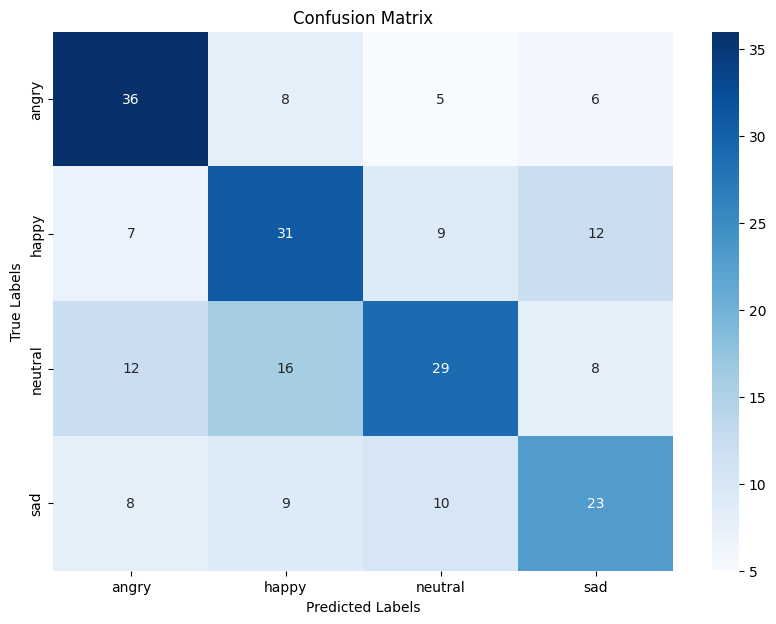

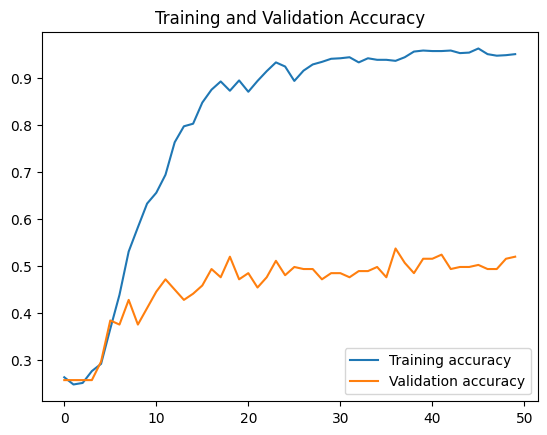

In [115]:
evaluate_model(model, X_test, y_test, history, encoder.classes_)


In [116]:
import pandas as pd
import numpy as np
speaker_ids_test = merged_df.iloc[idx_test]['Speaker_id'].tolist()

def evaluate_and_display_predictions_with_transcript_and_speaker(model, X_test, y_test, idx_test, class_labels, speaker_ids):
    # Predict the test set results
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Fetch transcripts and speaker_ids based on test indices
    transcripts = merged_df.iloc[idx_test]['Transcript'].tolist()

    # Convert numeric labels back to original labels
    predicted_labels = [class_labels[i] for i in y_pred_classes]
    true_labels = [class_labels[i] for i in y_true_classes]

    # Create a DataFrame to display the speaker_id, transcripts, true labels, predicted labels
    results_df = pd.DataFrame({
        'Speaker ID': speaker_ids,
        'Transcript': transcripts,
        'True Label': true_labels,
        'Predicted Label': predicted_labels,
        'Predicted Probability': np.max(y_pred, axis=1)
    })



    return results_df  # Return the DataFrame in case you need it for further analysis

# Usage of the function
class_labels = encoder.classes_
results_df = evaluate_and_display_predictions_with_transcript_and_speaker(model, X_test, y_test, idx_test, class_labels, speaker_ids_test)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
                 Speaker ID  \
0    Ses04F_script03_2_M001   
1    Ses05F_script01_3_F017   
2       Ses04F_impro07_F000   
3    Ses04F_script01_1_F018   
4       Ses04F_impro07_M040   
..                      ...   
224     Ses04F_impro01_M013   
225     Ses04F_impro07_M019   
226     Ses04F_impro01_F010   
227  Ses04F_script03_2_F036   
228     Ses05F_impro07_F022   

                                            Transcript True Label  \
0    I knew nothing of the sort.  You took presents...    neutral   
1    Like Larry's brother.  Do it like you, Chris. ...      angry   
2                               Guess what came today?    neutral   
3               Well that's only your business, Chris.        sad   
4                                             Vermont.      happy   
..                                                 ...        ...   
224                                and you filled out-      angry   
225                               So 

In [117]:
# Display the DataFrame
results_df

,Speaker ID,Transcript,True Label,Predicted Label,Predicted Probability
0,Ses04F_script03_2_M001,I knew nothing of the sort. You took presents...,neutral,angry,0.999421
1,Ses05F_script01_3_F017,"Like Larry's brother. Do it like you, Chris. ...",angry,angry,0.763039
2,Ses04F_impro07_F000,Guess what came today?,neutral,sad,0.991622
3,Ses04F_script01_1_F018,"Well that's only your business, Chris.",sad,sad,0.979199
4,Ses04F_impro07_M040,Vermont.,happy,angry,0.999979
...,...,...,...,...,...
224,Ses04F_impro01_M013,and you filled out-,angry,angry,0.999995
225,Ses04F_impro07_M019,So you're undecided?,neutral,neutral,0.860949
226,Ses04F_impro01_F010,"Okay. Well, I can do that right here right no...",angry,angry,0.999982
227,Ses04F_script03_2_F036,"Go away, go away. I hate you.",neutral,neutral,0.998403


In [92]:
merged_df

,Transcript,Emotion
0,whats going on,sad
1,kathy died last night,sad
2,oh my god oh my god im so sorry,sad
3,yeah i mean you know it was a,sad
4,i guess we saw it coming and she lasted a lot ...,sad
...,...,...
1267,well its not champagne,happy
1268,well than we dont need glasses,happy
1269,are you still cold you still want to go home,neutral
1270,no i am beginning to think that maybe this is ...,neutral


# **Model 2**

In [120]:
def build_model_2(vocab_size, output_size):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=85, trainable=True),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.3),
        Attention(return_sequences=False),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(output_size, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [121]:
model2 = build_model_2(vocab_size=10000, output_size=4)
history = model2.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 459ms/step - accuracy: 0.2363 - loss: 1.3883 - val_accuracy: 0.2576 - val_loss: 1.3872
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 551ms/step - accuracy: 0.2525 - loss: 1.3876 - val_accuracy: 0.2576 - val_loss: 1.3856
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 544ms/step - accuracy: 0.2807 - loss: 1.3851 - val_accuracy: 0.2576 - val_loss: 1.3840
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 425ms/step - accuracy: 0.2697 - loss: 1.3879 - val_accuracy: 0.2664 - val_loss: 1.3828
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 370ms/step - accuracy: 0.2764 - loss: 1.3818 - val_accuracy: 0.3013 - val_loss: 1.3614
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 342ms/step - accuracy: 0.3054 - loss: 1.3487 - val_accuracy: 0.3537 - val_loss: 1.3057
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 389ms/step - accuracy: 0.4129 - loss: 1.2351 - val_accuracy: 0.3188 - val_loss: 1.3112
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 281ms/step - accuracy: 0.4751 - loss: 1.1533 - val_accuracy: 0.3275

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.4351 - loss: 4.1033
Test Accuracy: 0.44541484117507935
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step
F1 Score: 0.443098845535067
Confusion Matrix:
 [[30  5 12  8]
 [10 28 10 11]
 [16 14 22 13]
 [ 9  8 11 22]]
              precision    recall  f1-score   support

           0       0.46      0.55      0.50        55
           1       0.51      0.47      0.49        59
           2       0.40      0.34      0.37        65
           3       0.41      0.44      0.42        50

    accuracy                           0.45       229
   macro avg       0.44      0.45      0.45       229
weighted avg       0.44      0.45      0.44       229



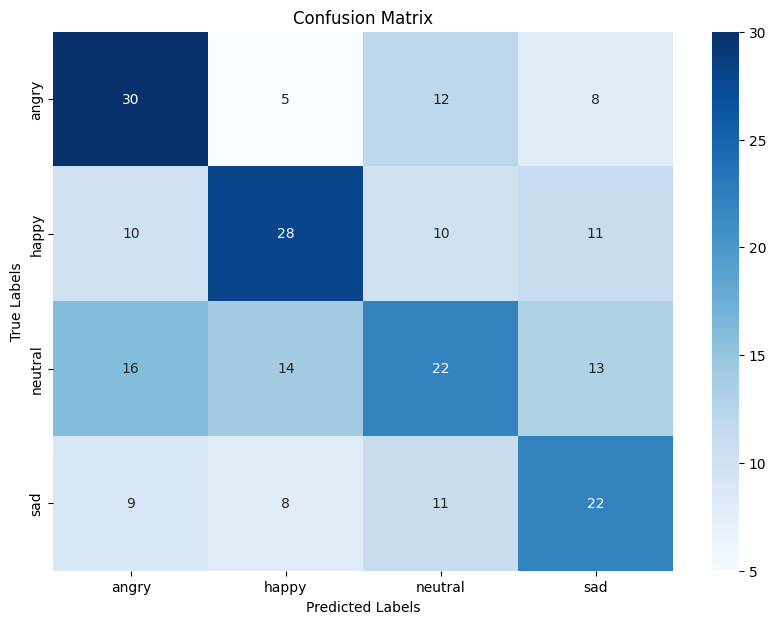

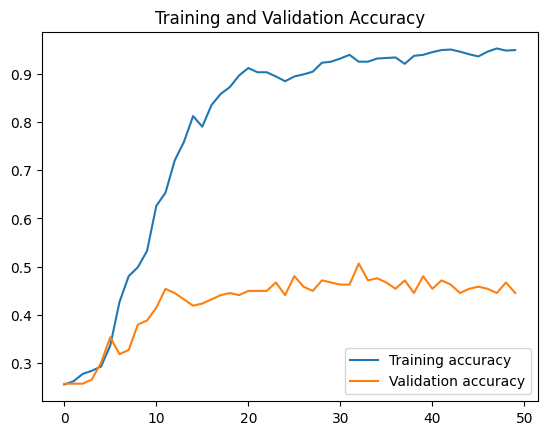

In [122]:
evaluate_model(model2, X_test, y_test, history, encoder.classes_)


In [129]:
merged_df[merged_df['Speaker_id'] == 'Ses02F_impro01_F019']

,Speaker_id,Transcript,Emotion


In [130]:
features_df[features_df['Speaker_id'] == 'Ses02F_impro01_F019']

,MFCC_0,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,...,LPC_3,LPC_4,LPC_5,LPC_6,LPC_7,LPC_8,LPC_9,LPC_10,Emotion,Speaker_id


In [131]:
df[df['Speaker_id'] == 'Ses02F_impro01_F019']

,Speaker_id,Transcript
3700,Ses02F_impro01_F019,"Yeah, but your birth certificate--I mean, who ..."


In [132]:
import os
import pandas as pd

def load_labels(base_path):
    data = []
    sessions = ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']

    # Iterate over each session
    for session in sessions:
        # Define the path to the labels folder
        label_path = os.path.join(base_path, session, 'dialog', 'EmoEvaluation', 'Categorical')

        # Check if the path exists
        if not os.path.exists(label_path):
            print(f"Path does not exist: {label_path}")
            continue

        # Loop through each text file in the folder
        for filename in os.listdir(label_path):
            file_path = os.path.join(label_path, filename)
            if filename.endswith('.txt'):
                # Open and process each file
                with open(file_path, 'r', encoding='utf-8') as file:
                    for line in file:
                        parts = line.strip().split(':')
                        if len(parts) == 2:
                            speaker_id = parts[0].strip()
                            emotion = parts[1].split(';')[0].strip()
                            data.append({'Speaker_id': speaker_id, 'Emotion': emotion})

    # Create a DataFrame from the collected data
    label_df = pd.DataFrame(data, columns=['Speaker_id', 'Emotion'])
    return label_df

# Example usage
base_path = '/content/drive/Shared drives/CS298/CS 297/IEMOCAP'
labels_df = load_labels(base_path)
print(labels_df.head())


            Speaker_id        Emotion
0  Ses01F_impro01_F000  Neutral state
1  Ses01F_impro01_F001  Neutral state
2  Ses01F_impro01_F002  Neutral state
3  Ses01F_impro01_F003  Neutral state
4  Ses01F_impro01_F004  Neutral state


In [133]:
labels_df

,Speaker_id,Emotion
0,Ses01F_impro01_F000,Neutral state
1,Ses01F_impro01_F001,Neutral state
2,Ses01F_impro01_F002,Neutral state
3,Ses01F_impro01_F003,Neutral state
4,Ses01F_impro01_F004,Neutral state
...,...,...
28840,Ses05M_impro04_M037,Anger
28841,Ses05M_impro04_M038,Frustration
28842,Ses05M_impro04_M039,Frustration
28843,Ses05M_impro04_M040,Anger


In [136]:
# Define a mapping from original labels to new labels
emotion_mapping = {
    'Neutral state': 'neutral',
    'Frustration': 'frustrated',
    'Anger': 'angry',
    'Surprise': 'neutral',  # Assuming 'Surprise' to 'neutral' if not sure where to map
    'Disgust': 'angry',  # Mapping 'Disgust' to 'angry' or consider removing if not relevant
    'Other': None,  # Remove 'Other' or map if it can be categorized
    'Sadness': 'sad',
    'Fear': 'neutral',  # Assuming 'Fear' to 'neutral' or map to 'angry' based on context
    'Happiness': 'happy',
    'Excited': 'happy'
}

# Apply the mapping to the Emotion column
labels_df['Emotion'] = labels_df['Emotion'].map(emotion_mapping)

# Remove any rows with None as Emotion (unmapped categories)
labels_df = labels_df.dropna(subset=['Emotion'])
labels_df

,Speaker_id,Emotion
0,Ses01F_impro01_F000,neutral
1,Ses01F_impro01_F001,neutral
2,Ses01F_impro01_F002,neutral
3,Ses01F_impro01_F003,neutral
4,Ses01F_impro01_F004,neutral
...,...,...
28840,Ses05M_impro04_M037,angry
28841,Ses05M_impro04_M038,frustrated
28842,Ses05M_impro04_M039,frustrated
28843,Ses05M_impro04_M040,angry


In [138]:
labels_df = labels_df[~labels_df['Emotion'].str.contains('frustrated', na=False)]
labels_df

,Speaker_id,Emotion
0,Ses01F_impro01_F000,neutral
1,Ses01F_impro01_F001,neutral
2,Ses01F_impro01_F002,neutral
3,Ses01F_impro01_F003,neutral
4,Ses01F_impro01_F004,neutral
...,...,...
28837,Ses05M_impro04_M034,angry
28839,Ses05M_impro04_M036,angry
28840,Ses05M_impro04_M037,angry
28843,Ses05M_impro04_M040,angry


In [137]:
# Get unique values in the 'Emotion' column
unique_emotions = labels_df['Emotion'].unique()

# Print the unique emotion labels
print("Unique Emotion Labels:", unique_emotions)


Unique Emotion Labels: ['neutral' 'frustrated' 'angry' 'sad' 'happy']
